In [324]:
import wrangle as w 
import pandas as pd
import numpy as np
import scipy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import regex as re
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import export_text
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from matplotlib.ticker import ScalarFormatter
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold

First I need to modify the dataframe and make a separate version of it for modeling; split, scale, fit_transform, make dataframes have the same columns (actor dummies may complicate this)

In [287]:
df = w.wrangle_df()

Using cached CSV


I originally wanted to one-hot encode for every instance of cast_actor_1, 2, and 3, but the resultant shape is so large as to become unworkable (at least in a reasonable time span.

In [288]:
df.production_company.value_counts().head(10)

UniversalPictures                     398
ParamountPictures                     386
TwentiethCenturyFoxFilmCorporation    291
ColumbiaPictures                      232
NewLineCinema                         184
WarnerBros.                           162
WaltDisneyPictures                    145
Metro-Goldwyn-Mayer(MGM)              107
ColumbiaPicturesCorporation           104
UnitedArtists                         101
Name: production_company, dtype: int64

In [289]:
threshold = 101
df.loc[df['production_company'].value_counts()\
       [df['production_company']].values < threshold, 'production_company'] = "other_company"

In [290]:
df.production_company.value_counts()

other_company                         4783
UniversalPictures                      398
ParamountPictures                      386
TwentiethCenturyFoxFilmCorporation     291
ColumbiaPictures                       232
NewLineCinema                          184
WarnerBros.                            162
WaltDisneyPictures                     145
Metro-Goldwyn-Mayer(MGM)               107
ColumbiaPicturesCorporation            104
UnitedArtists                          101
Name: production_company, dtype: int64

In [291]:
df.cast_actor_1.value_counts().head(10)

Nicolas Cage          41
Robert De Niro        37
Bruce Willis          36
Sylvester Stallone    35
Johnny Depp           34
Denzel Washington     33
Tom Hanks             33
Clint Eastwood        32
Tom Cruise            30
Robin Williams        26
Name: cast_actor_1, dtype: int64

In [292]:
threshold = 26
df.loc[df['cast_actor_1'].value_counts()\
       [df['cast_actor_1']].values < threshold, 'cast_actor_1'] = "other_actor"

In [293]:
df.cast_actor_1.value_counts()

other_actor              6452
Nicolas Cage               41
Robert De Niro             37
Bruce Willis               36
Sylvester Stallone         35
Johnny Depp                34
Tom Hanks                  33
Denzel Washington          33
Clint Eastwood             32
Tom Cruise                 30
Arnold Schwarzenegger      26
Kevin Costner              26
Robin Williams             26
John Travolta              26
Adam Sandler               26
Name: cast_actor_1, dtype: int64

In [294]:
dummy_group = ['cast_actor_1', 'production_company']
dummy_df = pd.get_dummies(df.loc[:,dummy_group])

In [295]:
keep =  ['budget','runtime', 'vote_average','vote_count', 'success', 
         'release_year', 'is_genre_adventure', 'is_genre_horror', 
         'is_genre_drama', 'is_genre_scifi', 'is_genre_romance',
         'is_genre_thriller', 'is_genre_crime', 'is_genre_comedy',
         'is_genre_animation', 'is_genre_action', 'is_genre_mystery',
         'is_genre_fantasy', 'is_genre_documentary', 'total_n_cast']
# success will be the only one of these that is not used as a predictor, given that it is our target
# I'm not sure if revenue would be appropriate to include. 

In [296]:
modeling_df = df.loc[:,keep]

In [297]:
# Concatenate dummy dataframe to original 
modeling_df = pd.concat([modeling_df, dummy_df], axis=1)

In [298]:
modeling_df.shape

(6893, 46)

In [299]:
modeling_df.columns

Index(['budget', 'runtime', 'vote_average', 'vote_count', 'success',
       'release_year', 'is_genre_adventure', 'is_genre_horror',
       'is_genre_drama', 'is_genre_scifi', 'is_genre_romance',
       'is_genre_thriller', 'is_genre_crime', 'is_genre_comedy',
       'is_genre_animation', 'is_genre_action', 'is_genre_mystery',
       'is_genre_fantasy', 'is_genre_documentary', 'total_n_cast',
       'cast_actor_1_Adam Sandler', 'cast_actor_1_Arnold Schwarzenegger',
       'cast_actor_1_Bruce Willis', 'cast_actor_1_Clint Eastwood',
       'cast_actor_1_Denzel Washington', 'cast_actor_1_John Travolta',
       'cast_actor_1_Johnny Depp', 'cast_actor_1_Kevin Costner',
       'cast_actor_1_Nicolas Cage', 'cast_actor_1_Robert De Niro',
       'cast_actor_1_Robin Williams', 'cast_actor_1_Sylvester Stallone',
       'cast_actor_1_Tom Cruise', 'cast_actor_1_Tom Hanks',
       'cast_actor_1_other_actor', 'production_company_ColumbiaPictures',
       'production_company_ColumbiaPicturesCorporatio

The data types are as they should be, as far as I know. 

In [300]:
train, validate, test = w.train_validate_test_split(modeling_df)

In [301]:
print('train:', train.shape)
print('validate:', validate.shape)
print('test:', test.shape)

train: (3859, 46)
validate: (1655, 46)
test: (1379, 46)


***
Time to scale

In [302]:
X_train = train.drop(columns=['success'])
y_train = train['success']

X_validate = validate.drop(columns=['success'])
y_validate = validate['success']

X_test = test.drop(columns=['success'])
y_test = test['success']

In [303]:
# Now I need to scale. 
needs_scaling = ['budget','runtime', 'vote_average',
                 'vote_count','release_year', 'total_n_cast']

In [304]:
#scaler = MinMaxScaler()
## Note that we only call .fit with the training data,
## but we use .transform to apply the scaling to all the data splits.
#scaler.fit(X_train[needs_scaling])
#
#X_train_scaled = pd.DataFrame(scaler.transform(X_train[needs_scaling]))
#X_validate_scaled = pd.DataFrame(scaler.transform(X_validate[needs_scaling]))
#X_test_scaled = pd.DataFrame(scaler.transform(X_test[needs_scaling]))

scaler = MinMaxScaler()
# Note that we only call .fit with the training data,
# but we use .transform to apply the scaling to all the data splits.
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_validate_scaled = scaler.transform(X_validate)
X_test_scaled = scaler.transform(X_test)

X_train = pd.DataFrame(X_train_scaled, index=X_train.index, columns = X_train.columns)
X_validate = pd.DataFrame(X_validate_scaled, index=X_validate.index, columns = X_validate.columns)
X_test = pd.DataFrame(X_test_scaled, index=X_test.index, columns = X_test.columns)

In [305]:
y_train.value_counts()

0    2358
1    1501
Name: success, dtype: int64

In [313]:
X_train['baseline_prediction'] = 0
X_validate['baseline_prediction'] = 0
X_test['baseline_prediction'] = 0

In [314]:
X_train.shape

(3859, 46)

In [315]:
y_train.shape

(3859,)

In [316]:
# in case I want it for later
#train_scaled = X_train.merge(ytdf, how='left', on=X_train.index)
#validate_scaled = X_validate.merge(yvdf, how='left', left_index = True, right_index = True)
#train_scaled = X_train.merge(ytedf, how='left', left_index = True, right_index = True)
train_scaled = X_train.copy()
train_scaled['success'] = y_train

validate_scaled = X_validate.copy()
validate_scaled['success'] = y_validate

test_scaled = X_test.copy()
test_scaled['success'] = y_test

In [317]:
print('train:', train_scaled.shape)
print('validate:', validate_scaled.shape)
print('test:', test_scaled.shape)

train: (3859, 47)
validate: (1655, 47)
test: (1379, 47)


In [369]:
# print grid search results
def print_cv_results(gs, title):
    print('\n -----------------------------------------')
    print(title)

    print(f'Best Score = {gs.best_score_:.4f}')
    print(f'Best Hyper-parameters = {gs.best_params_}')
    print()

    print('Test Scores:')
    test_means = gs.cv_results_['mean_test_score']
    test_stds = gs.cv_results_['std_test_score']
    for mean, std, params in zip(test_means, test_stds, gs.cv_results_['params']):
        print(f'{mean:.4f} (+/-{std:.3f}) for {params}')
    print()

    print('Training Scores:')
    train_means = gs.cv_results_['mean_train_score']
    train_stds = gs.cv_results_['std_train_score']
    for mean, std, params in zip(train_means, train_stds, gs.cv_results_['params']):
        print(f'{mean:.4f} (+/-{std:.3f}) for {params}')
    print('\n -----------------------------------------')
    
        # save grid search results to file
def save_cv_results(gs, title, fileName):
    with open(fileName, 'a') as f:
        
        print(title, file=f)

        print(f'Best Score = {gs.best_score_:.4f}', file=f)
        print(f'Best Hyper-parameters = {gs.best_params_}', file=f)
        print('', file=f)

        print('Test Scores:', file=f)
        test_means = gs.cv_results_['mean_test_score']
        test_stds = gs.cv_results_['std_test_score']
        for mean, std, params in zip(test_means, test_stds, gs.cv_results_['params']):
            print(f'{mean:.4f} (+/-{std:.3f}) for {params}', file=f)
        print('', file=f)

        print('Training Scores:', file=f)
        train_means = gs.cv_results_['mean_train_score']
        train_stds = gs.cv_results_['std_train_score']
        for mean, std, params in zip(train_means, train_stds, gs.cv_results_['params']):
            print(f'{mean:.4f} (+/-{std:.3f}) for {params}', file=f)

In [367]:
# Logistic Regression
logReg = LogisticRegression(max_iter=1000)
c_list = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid = {'C': c_list,
              'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']}

gs = GridSearchCV(estimator=logReg,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=3,
                  return_train_score=True)
gs = gs.fit(X_train, y_train)
print_cv_results(gs, 'Logistic Regression Accuracy')
#save_cv_results(gs, 'Logistic Regression Accuracy', 'Mastersheet')


 -----------------------------------------
Logistic Regression Accuracy
Best Score = 0.7746
Best Hyper-parameters = {'C': 100, 'solver': 'saga'}

Test Scores:
0.6110 (+/-0.000) for {'C': 0.001, 'solver': 'newton-cg'}
0.6110 (+/-0.000) for {'C': 0.001, 'solver': 'lbfgs'}
0.6110 (+/-0.000) for {'C': 0.001, 'solver': 'sag'}
0.6110 (+/-0.000) for {'C': 0.001, 'solver': 'saga'}
0.6393 (+/-0.002) for {'C': 0.01, 'solver': 'newton-cg'}
0.6393 (+/-0.002) for {'C': 0.01, 'solver': 'lbfgs'}
0.6393 (+/-0.002) for {'C': 0.01, 'solver': 'sag'}
0.6393 (+/-0.002) for {'C': 0.01, 'solver': 'saga'}
0.6968 (+/-0.005) for {'C': 0.1, 'solver': 'newton-cg'}
0.6968 (+/-0.005) for {'C': 0.1, 'solver': 'lbfgs'}
0.6968 (+/-0.005) for {'C': 0.1, 'solver': 'sag'}
0.6968 (+/-0.005) for {'C': 0.1, 'solver': 'saga'}
0.7398 (+/-0.008) for {'C': 1, 'solver': 'newton-cg'}
0.7398 (+/-0.008) for {'C': 1, 'solver': 'lbfgs'}
0.7398 (+/-0.008) for {'C': 1, 'solver': 'sag'}
0.7398 (+/-0.008) for {'C': 1, 'solver': 'saga'}


In [368]:
# Logistic Regression
logReg = LogisticRegression(max_iter=1000)
c_list = [ 1, 10, 100, 1000]
param_grid = {'C': c_list,
              'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']}

gs = GridSearchCV(estimator=logReg,
                  param_grid=param_grid,
                  scoring = 'precision',
                  cv=3,
                  return_train_score=True)
gs = gs.fit(X_train, y_train)
print_cv_results(gs, 'Logistic Regression Precision')
#save_cv_results(gs, 'Logistic Regression Precision', 'Mastersheet')


 -----------------------------------------
Logistic Regression Precision
Best Score = 0.7836
Best Hyper-parameters = {'C': 100, 'solver': 'saga'}

Test Scores:
0.7478 (+/-0.013) for {'C': 1, 'solver': 'newton-cg'}
0.7478 (+/-0.013) for {'C': 1, 'solver': 'lbfgs'}
0.7470 (+/-0.012) for {'C': 1, 'solver': 'sag'}
0.7478 (+/-0.013) for {'C': 1, 'solver': 'saga'}
0.7818 (+/-0.008) for {'C': 10, 'solver': 'newton-cg'}
0.7818 (+/-0.008) for {'C': 10, 'solver': 'lbfgs'}
0.7818 (+/-0.008) for {'C': 10, 'solver': 'sag'}
0.7826 (+/-0.009) for {'C': 10, 'solver': 'saga'}
0.7827 (+/-0.006) for {'C': 100, 'solver': 'newton-cg'}
0.7827 (+/-0.006) for {'C': 100, 'solver': 'lbfgs'}
0.7829 (+/-0.006) for {'C': 100, 'solver': 'sag'}
0.7836 (+/-0.005) for {'C': 100, 'solver': 'saga'}
0.7814 (+/-0.007) for {'C': 1000, 'solver': 'newton-cg'}
0.7814 (+/-0.007) for {'C': 1000, 'solver': 'lbfgs'}
0.7814 (+/-0.007) for {'C': 1000, 'solver': 'sag'}
0.7814 (+/-0.007) for {'C': 1000, 'solver': 'saga'}

Training S

In [373]:
# Logistic Regression
logReg = LogisticRegression(max_iter=10000)
c_list = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
param_grid = {'C': c_list,
              'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']}

gs = GridSearchCV(estimator=logReg,
                  param_grid=param_grid,
                  scoring='recall',
                  cv=3,
                  return_train_score=True)
gs = gs.fit(X_train, y_train)
print_cv_results(gs, 'Logistic Regression Recall')
#save_cv_results(gs, 'Logistic Regression Recall', 'Mastersheet')


 -----------------------------------------
Logistic Regression Recall
Best Score = 0.5836
Best Hyper-parameters = {'C': 10000, 'solver': 'newton-cg'}

Test Scores:
0.0000 (+/-0.000) for {'C': 0.001, 'solver': 'newton-cg'}
0.0000 (+/-0.000) for {'C': 0.001, 'solver': 'lbfgs'}
0.0000 (+/-0.000) for {'C': 0.001, 'solver': 'sag'}
0.0000 (+/-0.000) for {'C': 0.001, 'solver': 'saga'}
0.1799 (+/-0.008) for {'C': 0.01, 'solver': 'newton-cg'}
0.1799 (+/-0.008) for {'C': 0.01, 'solver': 'lbfgs'}
0.1799 (+/-0.008) for {'C': 0.01, 'solver': 'sag'}
0.1799 (+/-0.008) for {'C': 0.01, 'solver': 'saga'}
0.4111 (+/-0.005) for {'C': 0.1, 'solver': 'newton-cg'}
0.4111 (+/-0.005) for {'C': 0.1, 'solver': 'lbfgs'}
0.4111 (+/-0.005) for {'C': 0.1, 'solver': 'sag'}
0.4111 (+/-0.005) for {'C': 0.1, 'solver': 'saga'}
0.4997 (+/-0.020) for {'C': 1, 'solver': 'newton-cg'}
0.4997 (+/-0.020) for {'C': 1, 'solver': 'lbfgs'}
0.4997 (+/-0.020) for {'C': 1, 'solver': 'sag'}
0.4997 (+/-0.020) for {'C': 1, 'solver': 'sa


 -----------------------------------------
KNN Accuracy
Best Score = 0.6815
Best Hyper-parameters = {'n_neighbors': 19}

Test Scores:
0.6385 (+/-0.005) for {'n_neighbors': 1}
0.6600 (+/-0.001) for {'n_neighbors': 3}
0.6662 (+/-0.009) for {'n_neighbors': 5}
0.6740 (+/-0.010) for {'n_neighbors': 7}
0.6771 (+/-0.006) for {'n_neighbors': 9}
0.6784 (+/-0.009) for {'n_neighbors': 11}
0.6792 (+/-0.010) for {'n_neighbors': 13}
0.6805 (+/-0.004) for {'n_neighbors': 15}
0.6795 (+/-0.006) for {'n_neighbors': 17}
0.6815 (+/-0.008) for {'n_neighbors': 19}
0.6802 (+/-0.006) for {'n_neighbors': 21}
0.6776 (+/-0.006) for {'n_neighbors': 23}
0.6810 (+/-0.005) for {'n_neighbors': 25}

Training Scores:
1.0000 (+/-0.000) for {'n_neighbors': 1}
0.8275 (+/-0.004) for {'n_neighbors': 3}
0.7793 (+/-0.005) for {'n_neighbors': 5}
0.7607 (+/-0.007) for {'n_neighbors': 7}
0.7488 (+/-0.001) for {'n_neighbors': 9}
0.7400 (+/-0.001) for {'n_neighbors': 11}
0.7389 (+/-0.004) for {'n_neighbors': 13}
0.7337 (+/-0.001)

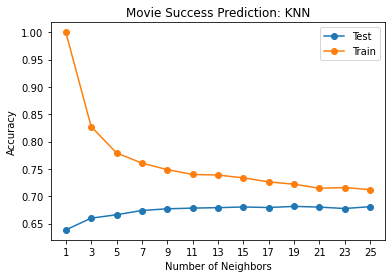

In [377]:
# # KNN
knn = KNeighborsClassifier()
k_list = list(range(1, 26, 2))
param_grid = [{'n_neighbors': k_list}]

gs = GridSearchCV(estimator=knn,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=3,
                  return_train_score=True)
gs = gs.fit(X_train, y_train)
print_cv_results(gs, 'KNN Accuracy')


test_means = gs.cv_results_['mean_test_score']
train_means = gs.cv_results_['mean_train_score']

plt.plot(k_list, test_means, marker='o', label='Test')
plt.plot(k_list, train_means, marker='o', label='Train')
plt.xticks(k_list)

plt.title('Movie Success Prediction: KNN')
plt.ylabel('Accuracy')
plt.xlabel('Number of Neighbors')
plt.legend()
plt.show()


 -----------------------------------------
KNN Precision
Best Score = 0.6623
Best Hyper-parameters = {'n_neighbors': 25}

Test Scores:
0.5364 (+/-0.009) for {'n_neighbors': 1}
0.5714 (+/-0.002) for {'n_neighbors': 3}
0.5871 (+/-0.015) for {'n_neighbors': 5}
0.6027 (+/-0.017) for {'n_neighbors': 7}
0.6121 (+/-0.012) for {'n_neighbors': 9}
0.6173 (+/-0.017) for {'n_neighbors': 11}
0.6224 (+/-0.016) for {'n_neighbors': 13}
0.6296 (+/-0.013) for {'n_neighbors': 15}
0.6370 (+/-0.018) for {'n_neighbors': 17}
0.6451 (+/-0.022) for {'n_neighbors': 19}
0.6474 (+/-0.021) for {'n_neighbors': 21}
0.6478 (+/-0.020) for {'n_neighbors': 23}
0.6623 (+/-0.016) for {'n_neighbors': 25}

Training Scores:
1.0000 (+/-0.000) for {'n_neighbors': 1}
0.8103 (+/-0.005) for {'n_neighbors': 3}
0.7618 (+/-0.008) for {'n_neighbors': 5}
0.7375 (+/-0.013) for {'n_neighbors': 7}
0.7306 (+/-0.002) for {'n_neighbors': 9}
0.7214 (+/-0.003) for {'n_neighbors': 11}
0.7283 (+/-0.002) for {'n_neighbors': 13}
0.7295 (+/-0.001

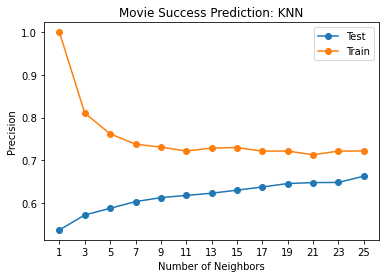

In [378]:
# # KNN
knn = KNeighborsClassifier()
k_list = list(range(1, 26, 2))
param_grid = [{'n_neighbors': k_list}]

gs = GridSearchCV(estimator=knn,
                  param_grid=param_grid,
                  scoring='precision',
                  cv=3,
                  return_train_score=True)
gs = gs.fit(X_train, y_train)
print_cv_results(gs, 'KNN Precision')


test_means = gs.cv_results_['mean_test_score']
train_means = gs.cv_results_['mean_train_score']

plt.plot(k_list, test_means, marker='o', label='Test')
plt.plot(k_list, train_means, marker='o', label='Train')
plt.xticks(k_list)

plt.title('Movie Success Prediction: KNN')
plt.ylabel('Precision')
plt.xlabel('Number of Neighbors')
plt.legend()
plt.show()


 -----------------------------------------
KNN Precision
Best Score = 0.5270
Best Hyper-parameters = {'n_neighbors': 1}

Test Scores:
0.5270 (+/-0.021) for {'n_neighbors': 1}
0.5043 (+/-0.016) for {'n_neighbors': 3}
0.4790 (+/-0.013) for {'n_neighbors': 5}
0.4750 (+/-0.013) for {'n_neighbors': 7}
0.4644 (+/-0.010) for {'n_neighbors': 9}
0.4564 (+/-0.014) for {'n_neighbors': 11}
0.4451 (+/-0.019) for {'n_neighbors': 13}
0.4350 (+/-0.010) for {'n_neighbors': 15}
0.4117 (+/-0.022) for {'n_neighbors': 17}
0.4064 (+/-0.032) for {'n_neighbors': 19}
0.3938 (+/-0.017) for {'n_neighbors': 21}
0.3784 (+/-0.031) for {'n_neighbors': 23}
0.3691 (+/-0.030) for {'n_neighbors': 25}

Training Scores:
1.0000 (+/-0.000) for {'n_neighbors': 1}
0.7268 (+/-0.011) for {'n_neighbors': 3}
0.6296 (+/-0.006) for {'n_neighbors': 5}
0.5976 (+/-0.005) for {'n_neighbors': 7}
0.5610 (+/-0.004) for {'n_neighbors': 9}
0.5400 (+/-0.004) for {'n_neighbors': 11}
0.5243 (+/-0.012) for {'n_neighbors': 13}
0.5013 (+/-0.006)

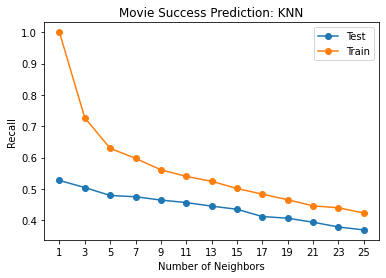

In [385]:
# # KNN
knn = KNeighborsClassifier()
k_list = list(range(1, 26, 2))
param_grid = [{'n_neighbors': k_list}]

gs = GridSearchCV(estimator=knn,
                  param_grid=param_grid,
                  scoring='recall',
                  cv=3,
                  return_train_score=True)
gs = gs.fit(X_train, y_train)
print_cv_results(gs, 'KNN Precision')


test_means = gs.cv_results_['mean_test_score']
train_means = gs.cv_results_['mean_train_score']

plt.plot(k_list, test_means, marker='o', label='Test')
plt.plot(k_list, train_means, marker='o', label='Train')
plt.xticks(k_list)

plt.title('Movie Success Prediction: KNN')
plt.ylabel('Recall')
plt.xlabel('Number of Neighbors')
plt.legend()
plt.show()


 -----------------------------------------
Decision Tree Regression Accuracy
Best Score = 0.7691
Best Hyper-parameters = {'max_depth': 6}

Test Scores:
0.7162 (+/-0.013) for {'max_depth': 1}
0.7175 (+/-0.014) for {'max_depth': 2}
0.7497 (+/-0.015) for {'max_depth': 3}
0.7556 (+/-0.011) for {'max_depth': 4}
0.7585 (+/-0.013) for {'max_depth': 5}
0.7691 (+/-0.014) for {'max_depth': 6}
0.7639 (+/-0.022) for {'max_depth': 7}
0.7644 (+/-0.010) for {'max_depth': 8}
0.7582 (+/-0.019) for {'max_depth': 9}
0.7492 (+/-0.014) for {'max_depth': 10}
0.7463 (+/-0.010) for {'max_depth': 11}
0.7414 (+/-0.010) for {'max_depth': 12}
0.7422 (+/-0.015) for {'max_depth': 13}
0.7341 (+/-0.016) for {'max_depth': 14}
0.7315 (+/-0.015) for {'max_depth': 15}
0.7315 (+/-0.019) for {'max_depth': 16}

Training Scores:
0.7298 (+/-0.004) for {'max_depth': 1}
0.7309 (+/-0.002) for {'max_depth': 2}
0.7633 (+/-0.004) for {'max_depth': 3}
0.7751 (+/-0.006) for {'max_depth': 4}
0.7940 (+/-0.007) for {'max_depth': 5}
0.8

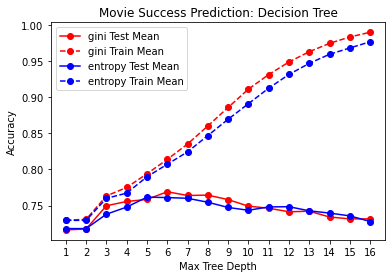

In [391]:
# ############################################################
# Decision Tree
criterion = ['gini', 'entropy']
colors = ['red', 'blue']
depth_list = list(range(1,17))

for i in range(len(criterion)):
    tree = DecisionTreeClassifier(criterion=criterion[i])
    param_grid = [{'max_depth': depth_list}]
    gs = GridSearchCV(estimator=tree,
                      param_grid=param_grid,
                      scoring='accuracy',
                      cv=5,
                     return_train_score=True)
    gs = gs.fit(X_train, y_train)
    print_cv_results(gs, 'Decision Tree Regression Accuracy')

    test_means = gs.cv_results_['mean_test_score']
    train_means = gs.cv_results_['mean_train_score']

    plt.plot(depth_list, test_means, marker='o', label=f'{criterion[i]} Test Mean',
                color=colors[i])
    plt.plot(depth_list, train_means, marker='o', label=f'{criterion[i]} Train Mean',
                linestyle='dashed', color=colors[i])

plt.xticks(depth_list)
plt.title(f'Movie Success Prediction: Decision Tree')
plt.ylabel('Accuracy')
plt.xlabel('Max Tree Depth')
plt.legend()
plt.show()


In [ ]:
def print_cv_results(gs, title):
    print('\n -----------------------------------------')
    print(title)

    print(f'Best Score = {gs.best_score_:.4f}')
    print(f'Best Hyper-parameters = {gs.best_params_}')
    print()

    print('Test Scores:')
    test_means = gs.cv_results_['mean_test_score']
    test_stds = gs.cv_results_['std_test_score']
    for mean, std, params in zip(test_means, test_stds, gs.cv_results_['params']):
        print(f'{mean:.4f} (+/-{std:.3f}) for {params}')
    print()

    print('Training Scores:')
    train_means = gs.cv_results_['mean_train_score']
    train_stds = gs.cv_results_['std_train_score']
    for mean, std, params in zip(train_means, train_stds, gs.cv_results_['params']):
        print(f'{mean:.4f} (+/-{std:.3f}) for {params}')
    print('\n -----------------------------------------')